In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using JLD
using CairoMakie

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [43]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= 0.07; k2 = 0.07
k = 0.0
tspan = (0.0, 300000.0)

(0.0, 300000.0)

In [44]:
k1_space = range(-0.5, 0.0, step = 0.01)
k_space = range(0.0, 0.5, step = 0.01)

0.0:0.01:0.5

In [45]:
length(k_space), length(k1_space)

(51, 51)

In [46]:
u0_map = zeros(length(k1_space), length(k_space), 6);
spectrum_map = zeros(length(k1_space), length(k_space), 6);
EE_map = zeros(length(k1_space), length(k_space));

In [47]:
for (i_index, k1) in enumerate(k1_space)
    for (j_index, k) in enumerate(k_space)
        
            if i_index == j_index && i_index == 1
                global u0 = SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
            end
            
            println("i index: $i_index;"); flush(stdout)
            println("j index: $j_index;"); flush(stdout)
            println("u0: $u0"); flush(stdout)
            u0_map[i_index, j_index, :] = u0
            p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]
        
            prob = ODEProblem(HR, u0, tspan, p)
            sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
            u0 = sol[end]
        
            ds_HR = ContinuousDynamicalSystem(HR, u0, p )
            spectrum = lyapunovspectrum(ds_HR, tspan[2]; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
            spectrum_map[i_index, j_index, :] = spectrum
            println("spectrum: $spectrum"); flush(stdout)
        
            if spectrum[1] > 0
                 xsum = sol[1,:] + sol[4,:]
                 println("x_sum before truncate length: ", length(xsum)); flush(stdout)
                 xsum = xsum[floor(Int, length(xsum) / 2):end ]
                 println("x_sum after truncate length: ", length(xsum)); flush(stdout)
    
                 Hs = Statistics.mean(xsum) + 6 * Statistics.std(xsum)
                 counts = xsum[xsum.>=Hs]
                 counts = length(counts)
                 EE_map[i_index, j_index]  = counts
    
                 println("counts: ", counts)
            end
        
            println("last point: $u0"); flush(stdout)
            println(" >>>>>> "); flush(stdout)
            println(""); flush(stdout)
    end
end

i index: 1;
j index: 1;
u0: [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
spectrum: [0.011694718648400809, 3.338098825293769e-5, -0.0036611150703078233, -0.013497680797649606, -6.497851138286808, -11.739801458156265]
x_sum before truncate length: 4296794
x_sum after truncate length: 2148398
counts: 75
last point: [-1.345336136025408, -8.073124226075285, 3.7861149500766196, -0.9201221034853521, -3.3199100239182258, 3.9877324357304933]
 >>>>>> 

i index: 1;
j index: 2;
u0: [-1.345336136025408, -8.073124226075285, 3.7861149500766196, -0.9201221034853521, -3.3199100239182258, 3.9877324357304933]
spectrum: [0.011863919758329176, 7.33281648567199e-5, -0.0022197602471950924, -0.012231910267391856, -6.465906110139735, -11.731990625910036]
x_sum before truncate length: 4281020
x_sum after truncate length: 2140511
counts: 47
last point: [-0.2300817436639527, 0.05367249957776275, 3.92833286069247, -1.078996284700609, -4.86622920897175, 3.9906633117811854]
 >>>>>> 

i index: 1;
j index: 3;
u0: [-0.230081743663

 >>>>>> 

i index: 1;
j index: 17;
u0: [-0.8321501646214341, -2.478095470449914, 4.13592182141264, -1.0715372624807882, -5.238446883579815, 3.42317323043069]
spectrum: [0.015374963578522078, 6.481104152728397e-5, -0.002280967430848313, -0.0163699344038733, -4.965684631654148, -13.197521759086998]
x_sum before truncate length: 4719808
x_sum after truncate length: 2359905
counts: 151
last point: [-0.7051219186624668, -1.9883540517301639, 3.651185832344998, -0.44765468972224914, -0.04336935428339812, 4.5965234898650476]
 >>>>>> 

i index: 1;
j index: 18;
u0: [-0.7051219186624668, -1.9883540517301639, 3.651185832344998, -0.44765468972224914, -0.04336935428339812, 4.5965234898650476]
spectrum: [-1.994816923934289e-6, -0.00043823901820190227, -0.012341930795416674, -0.012350463867152502, -4.305650046273108, -14.042162206183008]
last point: [-0.6024445579486821, -0.7761808619096616, 4.373771509957438, -0.3909799595459219, -0.5952091646823524, 3.6644071481655156]
 >>>>>> 

i index: 1;
j index:

 >>>>>> 

i index: 1;
j index: 33;
u0: [-1.6619178803160786, -12.285278977619399, 3.7546889571601074, -0.15230864148210418, 0.8697232442029165, 4.480054980365698]
spectrum: [0.016357999431721885, 3.250526092536045e-6, -0.011997651659581747, -0.028598752204137583, -4.988098787663805, -13.681861627428125]
x_sum before truncate length: 4780812
x_sum after truncate length: 2390407
counts: 70
last point: [-0.7063680080984437, -2.096453120727901, 3.4756111863660117, -1.288150386606817, -7.029182281681746, 4.291313687178738]
 >>>>>> 

i index: 1;
j index: 34;
u0: [-0.7063680080984437, -2.096453120727901, 3.4756111863660117, -1.288150386606817, -7.029182281681746, 4.291313687178738]
spectrum: [0.012644329891216236, 4.74709152174206e-6, -0.01136999639813993, -0.025123208810771562, -5.241599257621302, -13.45526970501076]
x_sum before truncate length: 4724515
x_sum after truncate length: 2362259
counts: 2
last point: [0.30813619483698207, 0.6134885192787614, 3.6169314259354346, -1.242461855638107

counts: 0
last point: [-0.19955027674894954, -1.3569561911923915, 3.748132635872676, -1.0471150929710302, -4.8067112442658075, 4.241695909749149]
 >>>>>> 

i index: 1;
j index: 49;
u0: [-0.19955027674894954, -1.3569561911923915, 3.748132635872676, -1.0471150929710302, -4.8067112442658075, 4.241695909749149]
spectrum: [0.021052879039031275, 1.0594681767120166e-5, -0.011947325921295415, -0.039655409356261544, -6.992080316487817, -11.437105030397401]
x_sum before truncate length: 4085918
x_sum after truncate length: 2042960
counts: 0
last point: [-0.30221723042577436, -0.33338491969979667, 3.4432808769264946, -0.3510581102847517, -0.7509360299211856, 3.3996168789393066]
 >>>>>> 

i index: 1;
j index: 50;
u0: [-0.30221723042577436, -0.33338491969979667, 3.4432808769264946, -0.3510581102847517, -0.7509360299211856, 3.3996168789393066]
spectrum: [0.020160056302593463, 9.813851329524648e-6, -0.01242106348489386, -0.038474826930998386, -6.97559713493519, -11.476144091165931]
x_sum before trunc

x_sum before truncate length: 4357702
x_sum after truncate length: 2178852
counts: 155
last point: [1.5596525227992868, -2.8446905390996315, 3.9023344477713535, -1.0083808462551063, -4.355830723554614, 4.197364992929803]
 >>>>>> 

i index: 2;
j index: 14;
u0: [1.5596525227992868, -2.8446905390996315, 3.9023344477713535, -1.0083808462551063, -4.355830723554614, 4.197364992929803]
spectrum: [0.02073052853626408, 0.003884968634368971, -6.834433161635065e-6, -0.011345585817563899, -5.703258687483116, -12.23805592579674]
x_sum before truncate length: 4403161
x_sum after truncate length: 2201582
counts: 149
last point: [-0.8242305399471489, -2.3233162118449417, 4.203746608776047, -1.4470756879978672, -9.191900074585151, 4.218575710945545]
 >>>>>> 

i index: 2;
j index: 15;
u0: [-0.8242305399471489, -2.3233162118449417, 4.203746608776047, -1.4470756879978672, -9.191900074585151, 4.218575710945545]
spectrum: [0.019688719519651815, 0.002539773009043204, -1.7128744621579656e-5, -0.01276746454385

x_sum before truncate length: 4785013
x_sum after truncate length: 2392508
counts: 23
last point: [-0.38281523588861366, 0.5576513356297588, 4.394910749544381, 0.6306018002543202, -3.5018237446898, 4.0712632587546524]
 >>>>>> 

i index: 2;
j index: 30;
u0: [-0.38281523588861366, 0.5576513356297588, 4.394910749544381, 0.6306018002543202, -3.5018237446898, 4.0712632587546524]
spectrum: [0.012044529195027178, -5.322562072754117e-6, -0.01192591925462607, -0.023864309773181876, -4.86912485085267, -13.770235527076556]
x_sum before truncate length: 4804236
x_sum after truncate length: 2402119
counts: 25
last point: [-1.2088490775898657, -5.716869748273535, 4.374817131897175, -0.37109570133500147, 0.09536553760179643, 4.257921186603676]
 >>>>>> 

i index: 2;
j index: 31;
u0: [-1.2088490775898657, -5.716869748273535, 4.374817131897175, -0.37109570133500147, 0.09536553760179643, 4.257921186603676]
spectrum: [0.017935417260287585, 5.111727801463912e-6, -0.011132986363867345, -0.024806287056067303

spectrum: [0.02086858361729318, 2.3741428475882066e-5, -0.007566374104874664, -0.030824407878450217, -6.4441568322890275, -12.175021269074906]
x_sum before truncate length: 4306604
x_sum after truncate length: 2153303
counts: 0
last point: [-0.6396383637231021, -0.9086032305855128, 3.731354664930231, -0.015575889038653213, 0.762808533889831, 4.284959788204184]
 >>>>>> 

i index: 2;
j index: 46;
u0: [-0.6396383637231021, -0.9086032305855128, 3.731354664930231, -0.015575889038653213, 0.762808533889831, 4.284959788204184]
spectrum: [0.01496486080673519, 3.28280640185924e-6, -0.005514253885138279, -0.03199076107100878, -6.632388494420707, -11.914614481766275]
x_sum before truncate length: 4242660
x_sum after truncate length: 2121331
counts: 0
last point: [-1.361090530672576, -8.322870645148594, 4.044238206802382, -0.600812675101236, -0.40374711093779797, 4.631937108481941]
 >>>>>> 

i index: 2;
j index: 47;
u0: [-1.361090530672576, -8.322870645148594, 4.044238206802382, -0.600812675101236,

 >>>>>> 

i index: 3;
j index: 10;
u0: [-0.9791229924712082, -4.417724149776767, 3.3306613922925052, -0.9174060170389597, -3.0222055481418306, 4.2911523370323135]
spectrum: [0.017684040360042855, 0.004030931899107363, -9.211600163494598e-7, -0.0065539620299345834, -6.140733339271508, -11.81279462927449]
x_sum before truncate length: 4242396
x_sum after truncate length: 2121199
counts: 115
last point: [-1.2983714548420848, -6.146620479767379, 3.9881784792963666, -0.23475059933726378, -3.524465262953663, 4.067084253623703]
 >>>>>> 

i index: 3;
j index: 11;
u0: [-1.2983714548420848, -6.146620479767379, 3.9881784792963666, -0.23475059933726378, -3.524465262953663, 4.067084253623703]
spectrum: [0.019205797274400086, 0.004587701721090624, -1.8774865970366487e-8, -0.007136074645426191, -6.077495576556876, -11.847886905417258]
x_sum before truncate length: 4258539
x_sum after truncate length: 2129271
counts: 120
last point: [-1.0556242611643556, -3.4616189715435968, 3.860661647253296, 0.20135

 >>>>>> 

i index: 3;
j index: 26;
u0: [-1.2483877394769494, -7.419990768850974, 3.2259127951889774, -0.9274273136445836, -2.6997412377556347, 4.670236882402112]
spectrum: [6.833769347308999e-6, -0.0032580857537354703, -0.01670257852635339, -0.03274038241781409, -4.185968982968773, -14.26368821602909]
x_sum before truncate length: 4783398
x_sum after truncate length: 2391700
counts: 0
last point: [-0.2936570396220978, 0.10911530533573009, 4.024605045270228, -1.1133061678071998, -5.540683909539046, 3.8048212973794193]
 >>>>>> 

i index: 3;
j index: 27;
u0: [-0.2936570396220978, 0.10911530533573009, 4.024605045270228, -1.1133061678071998, -5.540683909539046, 3.8048212973794193]
spectrum: [1.1478041651989748e-6, -0.010722428785598247, -0.016818393838413156, -0.047500603717933056, -4.161055789532253, -14.403425018721235]
x_sum before truncate length: 4874672
x_sum after truncate length: 2437337
counts: 0
last point: [0.35757856801676574, 0.5675830348376932, 3.5952179163556037, -1.353354639

x_sum after truncate length: 2239234
counts: 0
last point: [-0.14309854099003927, 0.8877654742123532, 4.156065793834927, 0.523537820333571, 0.46463196717675975, 4.0585916139737215]
 >>>>>> 

i index: 3;
j index: 42;
u0: [-0.14309854099003927, 0.8877654742123532, 4.156065793834927, 0.523537820333571, 0.46463196717675975, 4.0585916139737215]
spectrum: [0.01604029170275176, 3.892955828883765e-6, -0.006743469571642224, -0.034933108602559645, -5.781619184657572, -12.760570295617589]
x_sum before truncate length: 4464222
x_sum after truncate length: 2232112
counts: 0
last point: [0.4591408668378465, -1.8680881143873476, 4.119112978966285, -0.038607616143152335, -0.12964213943762426, 3.7480322678475515]
 >>>>>> 

i index: 3;
j index: 43;
u0: [0.4591408668378465, -1.8680881143873476, 4.119112978966285, -0.038607616143152335, -0.12964213943762426, 3.7480322678475515]
spectrum: [0.013122832234283231, 1.1447499303019692e-5, -0.00746987605887525, -0.036484339918764916, -5.678989154898242, -12.8437

x_sum before truncate length: 4210648
x_sum after truncate length: 2105325
counts: 63
last point: [-0.8939724396946863, -2.9743499739444976, 4.138398753302051, -0.762965043811323, -2.2720138887002523, 3.8579475695599688]
 >>>>>> 

i index: 4;
j index: 7;
u0: [-0.8939724396946863, -2.9743499739444976, 4.138398753302051, -0.762965043811323, -2.2720138887002523, 3.8579475695599688]
spectrum: [0.016375059902156083, 0.0024664537959083912, 2.061084672368656e-5, -0.007459503356998491, -6.338186730670315, -11.652563594057122]
x_sum before truncate length: 4202394
x_sum after truncate length: 2101198
counts: 86
last point: [-1.4911434495740632, -8.907428926454017, 3.6709743887138893, 0.9127548683574648, -4.964950122987071, 4.04612613371635]
 >>>>>> 

i index: 4;
j index: 8;
u0: [-1.4911434495740632, -8.907428926454017, 3.6709743887138893, 0.9127548683574648, -4.964950122987071, 4.04612613371635]
spectrum: [0.018252747280888607, 0.0035320201974805058, -1.509203492610978e-5, -0.007319805542529086

spectrum: [7.095535702579651e-6, -0.011270889029140491, -0.011278013141138814, -0.01976566442261756, -3.972884578317198, -14.904434197954325]
x_sum before truncate length: 5105542
x_sum after truncate length: 2552772
counts: 0
last point: [1.2479177818415743, -3.4582694065767434, 3.97286508290752, -1.2320701782113752, -7.313209694382816, 3.8095427961738237]
 >>>>>> 

i index: 4;
j index: 23;
u0: [1.2479177818415743, -3.4582694065767434, 3.97286508290752, -1.2320701782113752, -7.313209694382816, 3.8095427961738237]
spectrum: [2.804717031768041e-6, -0.015829630148656626, -0.015840042075151203, -0.02712908066648446, -3.9065342960571017, -14.999126555283231]
x_sum before truncate length: 5154046
x_sum after truncate length: 2577024
counts: 0
last point: [-0.6309691711590757, -1.2371792026424306, 4.0471894111035995, -1.1589436268310216, -5.943683609002879, 3.740889125403149]
 >>>>>> 

i index: 4;
j index: 24;
u0: [-0.6309691711590757, -1.2371792026424306, 4.0471894111035995, -1.158943626831

 >>>>>> 

i index: 4;
j index: 38;
u0: [-0.22772368509693078, 0.2525536041310647, 3.9630460637196108, -0.9300588839625591, -3.803343688146184, 3.890266952261979]
spectrum: [6.143070289446401e-6, -0.007268722558744381, -0.010129828654175638, -0.03139441436212754, -5.099769627445967, -13.473381992009848]
x_sum before truncate length: 4681982
x_sum after truncate length: 2340992
counts: 0
last point: [-1.250229684515185, -6.6525026905709606, 3.840419708664487, -0.3186936403392052, 0.2345175747470947, 4.192118290617139]
 >>>>>> 

i index: 4;
j index: 39;
u0: [-1.250229684515185, -6.6525026905709606, 3.840419708664487, -0.3186936403392052, 0.2345175747470947, 4.192118290617139]
spectrum: [0.019899910241695268, 2.224187232185835e-6, -0.01061926061695421, -0.029898557235191105, -5.926417257719943, -12.721345404377416]
x_sum before truncate length: 4501615
x_sum after truncate length: 2250809
counts: 0
last point: [-0.35208578862763085, -0.1871793189709658, 3.71026459554178, -1.274831846727928

counts: 93
last point: [-0.941942210370672, -3.6978672375285875, 3.7664736411594024, -1.0913307107902006, -5.026683110955375, 3.8395967529688746]
 >>>>>> 

i index: 5;
j index: 3;
u0: [-0.941942210370672, -3.6978672375285875, 3.7664736411594024, -1.0913307107902006, -5.026683110955375, 3.8395967529688746]
spectrum: [0.015054243155223006, 0.000617629103728313, -0.0008810878686006425, -0.012099477267484289, -6.492967099389829, -11.590087941496337]
x_sum before truncate length: 4213359
x_sum after truncate length: 2106681
counts: 98
last point: [-1.132892870091424, -5.736693202717325, 3.5330121009613484, -1.327134691399001, -7.741874421696551, 3.886423528856117]
 >>>>>> 

i index: 5;
j index: 4;
u0: [-1.132892870091424, -5.736693202717325, 3.5330121009613484, -1.327134691399001, -7.741874421696551, 3.886423528856117]
spectrum: [0.015089450853171336, 0.0008156832274387785, -0.0005171598729594529, -0.01095668705361152, -6.4495344316139045, -11.606394308858155]
x_sum before truncate length: 

x_sum before truncate length: 4794317
x_sum after truncate length: 2397160
counts: 0
last point: [-0.8855651641267772, -3.923699348907701, 3.0170032328824727, -0.7054352395403476, -1.1237655153001076, 4.747581755392098]
 >>>>>> 

i index: 5;
j index: 19;
u0: [-0.8855651641267772, -3.923699348907701, 3.0170032328824727, -0.7054352395403476, -1.1237655153001076, 4.747581755392098]
spectrum: [5.0103339274263515e-6, -0.004566972594652178, -0.0063495527564988745, -0.016859775720321442, -4.171501536311987, -14.324830775575894]
x_sum before truncate length: 4832068
x_sum after truncate length: 2416035
counts: 0
last point: [-1.5264186078924618, -10.821541165400367, 3.8392425460266293, -0.6366672661213699, -1.1001215076266677, 4.200875479434605]
 >>>>>> 

i index: 5;
j index: 20;
u0: [-1.5264186078924618, -10.821541165400367, 3.8392425460266293, -0.6366672661213699, -1.1001215076266677, 4.200875479434605]
spectrum: [4.289373866252179e-6, -0.005164830133337827, -0.00787067917763285, -0.01924397

x_sum before truncate length: 4633102
x_sum after truncate length: 2316552
counts: 0
last point: [-0.8823164757718003, -3.4287660262713895, 3.319364458797176, -1.5131271014717036, -10.539186485478817, 3.9934925163136823]
 >>>>>> 

i index: 5;
j index: 35;
u0: [-0.8823164757718003, -3.4287660262713895, 3.319364458797176, -1.5131271014717036, -10.539186485478817, 3.9934925163136823]
spectrum: [1.170252821544166e-6, -0.002252058614236752, -0.017160034449088563, -0.03841057226512723, -5.418261620617533, -13.247189230794296]
x_sum before truncate length: 4652651
x_sum after truncate length: 2326327
counts: 0
last point: [-1.2517765239589846, -7.162405234572179, 3.42382240923882, -1.3976763205391862, -8.235327217864958, 4.439025587882811]
 >>>>>> 

i index: 5;
j index: 36;
u0: [-1.2517765239589846, -7.162405234572179, 3.42382240923882, -1.3976763205391862, -8.235327217864958, 4.439025587882811]
spectrum: [7.412779276183785e-6, -0.0028189779826583287, -0.0028289837774864413, -0.01918029825312

spectrum: [0.018370789940320778, 5.590894820821861e-6, -0.008353969826949272, -0.03472409787598385, -7.011181505421945, -11.62489243118057]
x_sum before truncate length: 4133169
x_sum after truncate length: 2066586
counts: 0
last point: [-0.7443502174360711, -1.9594636395326421, 3.626144447449595, 0.7752789987136846, -2.2187636426667985, 3.6625645898826686]
 >>>>>> 

i index: 5;
j index: 51;
u0: [-0.7443502174360711, -1.9594636395326421, 3.626144447449595, 0.7752789987136846, -2.2187636426667985, 3.6625645898826686]
spectrum: [1.8561383486889312e-5, -0.00018007299625067774, -0.005586294879334301, -0.03289454033876025, -7.1048664476569785, -11.456653554490815]
x_sum before truncate length: 4094588
x_sum after truncate length: 2047295
counts: 0
last point: [-0.6251887914314642, -1.01751438923473, 3.894528694137831, -0.1822318151695317, 0.26712845349852954, 3.915959714889557]
 >>>>>> 

i index: 6;
j index: 1;
u0: [-0.6251887914314642, -1.01751438923473, 3.894528694137831, -0.1822318151695


i index: 6;
j index: 15;
u0: [-1.0856063082222787, -5.578743857461146, 3.1971782168483496, -0.8426960605455291, -2.4429225434258286, 4.26730305469903]
spectrum: [0.020055314197160036, 0.0035985270617034386, -3.2359319774247087e-6, -0.010726885509995005, -5.60832411914267, -12.292998448709268]
x_sum before truncate length: 4403637
x_sum after truncate length: 2201820
counts: 175
last point: [-0.5839491338211642, -1.354693490143075, 3.7103155958655343, -0.6522004627034839, -1.0072291083983984, 4.580687889926743]
 >>>>>> 

i index: 6;
j index: 16;
u0: [-0.5839491338211642, -1.354693490143075, 3.7103155958655343, -0.6522004627034839, -1.0072291083983984, 4.580687889926743]
spectrum: [0.02052724958433616, 0.002273918049719866, -1.5533158247261637e-5, -0.012770668297490472, -5.417344976518594, -12.526647068750423]
x_sum before truncate length: 4456951
x_sum after truncate length: 2228477
counts: 218
last point: [-1.3562145369344065, -7.886751102344689, 4.221310965930208, -0.6220206977572951

x_sum before truncate length: 4872831
x_sum after truncate length: 2436417
counts: 0
last point: [-1.1605799060523634, -6.190590982942451, 3.304184220585697, -1.3908222998492479, -8.165374898033972, 4.429516062226652]
 >>>>>> 

i index: 6;
j index: 32;
u0: [-1.1605799060523634, -6.190590982942451, 3.304184220585697, -1.3908222998492479, -8.165374898033972, 4.429516062226652]
spectrum: [9.742026170639289e-6, -0.0029925841701351416, -0.003008596095863179, -0.02388059290129487, -4.528148486455218, -14.116859736718121]
x_sum before truncate length: 4893069
x_sum after truncate length: 2446536
counts: 0
last point: [-1.663071918715526, -12.307850413936343, 3.691401834209461, -0.06776296858408788, 0.9608273907290186, 4.48327696736685]
 >>>>>> 

i index: 6;
j index: 33;
u0: [-1.663071918715526, -12.307850413936343, 3.691401834209461, -0.06776296858408788, 0.9608273907290186, 4.48327696736685]
spectrum: [0.021433067891556103, 3.4736481693271387e-6, -0.011596605072527215, -0.02797132639168951, 

spectrum: [0.01825788257237223, -8.441137017853822e-6, -0.007156367169515132, -0.03424722848034431, -6.784864411002026, -11.84389053651901]
x_sum before truncate length: 4202060
x_sum after truncate length: 2101031
counts: 0
last point: [-0.8633557789109305, -2.9914111957780487, 3.6653068710670733, -1.279500175291679, -6.751373009424951, 4.4769221445611285]
 >>>>>> 

i index: 6;
j index: 48;
u0: [-0.8633557789109305, -2.9914111957780487, 3.6653068710670733, -1.279500175291679, -6.751373009424951, 4.4769221445611285]
spectrum: [0.01810145984212429, -1.4947724378443702e-6, -0.008365869409270789, -0.03441827653878754, -6.890182646465564, -11.73241607935011]
x_sum before truncate length: 4157700
x_sum after truncate length: 2078851
counts: 0
last point: [-0.7468915669223304, -1.3867945026131414, 4.052011551513309, 0.3544000951874212, 0.5892965450356578, 4.4432784832926995]
 >>>>>> 

i index: 6;
j index: 49;
u0: [-0.7468915669223304, -1.3867945026131414, 4.052011551513309, 0.354400095187421

 >>>>>> 

i index: 7;
j index: 12;
u0: [-0.6452608333826413, -1.535548000080898, 3.848588467460998, -1.171135877700627, -5.901087856947867, 3.870505555717763]
spectrum: [0.019871154023038542, 0.004843255835940315, 1.9161089003394977e-7, -0.006443049178345538, -6.023027332757301, -11.840268989799505]
x_sum before truncate length: 4233047
x_sum after truncate length: 2116525
counts: 158
last point: [-1.1963528859706816, -6.408308040413506, 3.5516534041136585, -1.40816786141415, -8.749866856643829, 4.023816824564239]
 >>>>>> 

i index: 7;
j index: 13;
u0: [-1.1963528859706816, -6.408308040413506, 3.5516534041136585, -1.40816786141415, -8.749866856643829, 4.023816824564239]
spectrum: [0.020853786254632342, 0.00424857093503007, -6.127989156026508e-6, -0.008288780117238674, -5.923288609717817, -11.936214443760877]
x_sum before truncate length: 4273255
x_sum after truncate length: 2136629
counts: 181
last point: [-1.311535338684982, -7.697761190014186, 3.767187244109507, -0.7505595107719678, 

counts: 0
last point: [-0.7538199854887503, -2.6433245941519887, 3.2153749576476014, -1.3619259017078564, -7.815227868848863, 4.463715264158041]
 >>>>>> 

i index: 7;
j index: 28;
u0: [-0.7538199854887503, -2.6433245941519887, 3.2153749576476014, -1.3619259017078564, -7.815227868848863, 4.463715264158041]
spectrum: [0.018912868837838166, 5.225295298198302e-7, -0.00892193106999977, -0.026341162820160816, -4.912548822360701, -13.586618885074389]
x_sum before truncate length: 4728414
x_sum after truncate length: 2364208
counts: 84
last point: [-0.9582015080169379, -2.5244767528830288, 4.343373332011765, -0.027639000459156172, 0.6759460037530212, 4.16828398755249]
 >>>>>> 

i index: 7;
j index: 29;
u0: [-0.9582015080169379, -2.5244767528830288, 4.343373332011765, -0.027639000459156172, 0.6759460037530212, 4.16828398755249]
spectrum: [0.01898610923699284, 7.773200817016936e-6, -0.00841238500651626, -0.02330941100406028, -4.981745807279223, -13.507181149820722]
x_sum before truncate length: 

x_sum after truncate length: 2178236
counts: 0
last point: [-1.34093412313498, -8.029442078335075, 3.7519701383309747, -1.3899275780220226, -8.107093707957365, 4.430263338296772]
 >>>>>> 

i index: 7;
j index: 44;
u0: [-1.34093412313498, -8.029442078335075, 3.7519701383309747, -1.3899275780220226, -8.107093707957365, 4.430263338296772]
spectrum: [0.016643912441669656, 2.780408610499492e-6, -0.006450375073150544, -0.036716268853089165, -6.24761705167513, -12.321299798178071]
x_sum before truncate length: 4341111
x_sum after truncate length: 2170557
counts: 0
last point: [-1.188766887197053, -5.289854237000756, 3.8996802028837134, 0.14615415063838638, 0.5488894175748927, 4.354250811781452]
 >>>>>> 

i index: 7;
j index: 45;
u0: [-1.188766887197053, -5.289854237000756, 3.8996802028837134, 0.14615415063838638, 0.5488894175748927, 4.354250811781452]
spectrum: [0.01944184957132519, 5.518452312033088e-7, -0.007458880639247316, -0.03609919533915836, -6.6238391229820515, -12.03003057512895]
x_s

x_sum before truncate length: 4165958
x_sum after truncate length: 2082980
counts: 129
last point: [-1.1866546838063734, -6.133149751607486, 3.769667626459242, -0.6714188352566891, -1.7132308233772744, 3.826942983571095]
 >>>>>> 

i index: 8;
j index: 9;
u0: [-1.1866546838063734, -6.133149751607486, 3.769667626459242, -0.6714188352566891, -1.7132308233772744, 3.826942983571095]
spectrum: [0.017926967352487746, 0.0038438663208075754, -1.2279208280816236e-5, -0.006114654503955014, -6.273027884641816, -11.611171475560695]
x_sum before truncate length: 4166625
x_sum after truncate length: 2083314
counts: 115
last point: [-0.3329794693427288, 0.13789417009275537, 4.121330431873766, -0.8377165273574738, -3.220633577712006, 3.994134023936532]
 >>>>>> 

i index: 8;
j index: 10;
u0: [-0.3329794693427288, 0.13789417009275537, 4.121330431873766, -0.8377165273574738, -3.220633577712006, 3.994134023936532]
spectrum: [0.01934617107230844, 0.004095479947583201, 3.8859963787258004e-6, -0.0062043045216

x_sum before truncate length: 4745204
x_sum after truncate length: 2372603
counts: 143
last point: [-1.7270264507790751, -14.06819052957407, 3.30051255210665, -0.18151130292770631, 0.9080199234974847, 4.7196456782956835]
 >>>>>> 

i index: 8;
j index: 25;
u0: [-1.7270264507790751, -14.06819052957407, 3.30051255210665, -0.18151130292770631, 0.9080199234974847, 4.7196456782956835]
spectrum: [0.01796739373380452, 5.212653554615752e-6, -0.0064959640973696765, -0.02107249501359624, -4.656475365824385, -13.74329721601458]
x_sum before truncate length: 4726567
x_sum after truncate length: 2363285
counts: 112
last point: [-1.381099334118958, -7.794786915166872, 4.491378108297863, -0.35966658989121414, 0.37215397944269657, 4.575207696460089]
 >>>>>> 

i index: 8;
j index: 26;
u0: [-1.381099334118958, -7.794786915166872, 4.491378108297863, -0.35966658989121414, 0.37215397944269657, 4.575207696460089]
spectrum: [1.2302929694356393e-5, -0.003994901061076317, -0.004007047408484903, -0.0251685527396

x_sum before truncate length: 4412547
x_sum after truncate length: 2206275
counts: 0
last point: [-1.5179165931941379, -10.742965985751919, 3.5820428687492516, -0.31242426698031844, 0.6696349760971642, 4.587077121108494]
 >>>>>> 

i index: 8;
j index: 41;
u0: [-1.5179165931941379, -10.742965985751919, 3.5820428687492516, -0.31242426698031844, 0.6696349760971642, 4.587077121108494]
spectrum: [0.020523678383109627, 6.998233298188603e-6, -0.009895786343706742, -0.0314077463493152, -6.228274887132573, -12.378959067202786]
x_sum before truncate length: 4389155
x_sum after truncate length: 2194579
counts: 0
last point: [-1.404860814952792, -8.954570649980132, 3.686865046088851, -1.5175964782120777, -10.125872959741987, 4.345133735268216]
 >>>>>> 

i index: 8;
j index: 42;
u0: [-1.404860814952792, -8.954570649980132, 3.686865046088851, -1.5175964782120777, -10.125872959741987, 4.345133735268216]
spectrum: [0.02092535947301434, 1.7675654992209873e-5, -0.008692540739035573, -0.03019169544559588

spectrum: [0.016724655615351847, 0.0018045942202767633, -0.0001784858879028979, -0.010210239185561699, -6.466496576028849, -11.48631752574462]
x_sum before truncate length: 4144343
x_sum after truncate length: 2072173
counts: 95
last point: [-0.9486039043155594, -3.94709946380356, 3.6494105166356774, -0.9156139298519937, -3.164346854030596, 4.123753365826796]
 >>>>>> 

i index: 9;
j index: 6;
u0: [-0.9486039043155594, -3.94709946380356, 3.6494105166356774, -0.9156139298519937, -3.164346854030596, 4.123753365826796]
spectrum: [0.017187963192407684, 0.002710550932166664, -3.1251874425473075e-6, -0.009231260495572583, -6.434931083636371, -11.482116092645358]
x_sum before truncate length: 4157298
x_sum after truncate length: 2078650
counts: 139
last point: [-0.9092582923851541, -3.750691783868573, 3.3836801900604265, -1.354444371000153, -8.359273371699752, 3.6360671597847194]
 >>>>>> 

i index: 9;
j index: 7;
u0: [-0.9092582923851541, -3.750691783868573, 3.3836801900604265, -1.354444371000

 >>>>>> 

i index: 9;
j index: 21;
u0: [-1.4937025907505537, -10.319750062348282, 3.8135796145673044, -0.5731283974055851, -0.7495989081858964, 4.228160485837043]
spectrum: [9.685577077259662e-6, -0.006686571873399378, -0.016184181697957458, -0.01618487825615548, -3.996065026893381, -14.685575570401681]
x_sum before truncate length: 4936630
x_sum after truncate length: 2468316
counts: 0
last point: [-1.700369367435438, -13.423432041251802, 3.303921487232072, -0.1378501186349237, 0.9094730066169061, 4.676890098408047]
 >>>>>> 

i index: 9;
j index: 22;
u0: [-1.700369367435438, -13.423432041251802, 3.303921487232072, -0.1378501186349237, 0.9094730066169061, 4.676890098408047]
spectrum: [1.2419704398578785e-5, -0.010829614190835427, -0.02442751604322696, -0.02444059038124631, -3.9374562219776963, -14.80400479772899]
x_sum before truncate length: 5041191
x_sum after truncate length: 2520597
counts: 0
last point: [-0.787115554704874, -2.6066686578143954, 3.527415776234418, -1.45796225131966

counts: 0
last point: [-0.888264827519169, -2.3861615967822916, 4.213635359177726, 0.9961464885901697, -2.0333079230910105, 4.047716787050652]
 >>>>>> 

i index: 9;
j index: 37;
u0: [-0.888264827519169, -2.3861615967822916, 4.213635359177726, 0.9961464885901697, -2.0333079230910105, 4.047716787050652]
spectrum: [0.023710612930956866, -4.895179429127402e-6, -0.011329669276010318, -0.028644136681952523, -6.017780936746898, -12.576445833614791]
x_sum before truncate length: 4448741
x_sum after truncate length: 2224372
counts: 0
last point: [-1.0777350430796424, -5.212701638665826, 3.4647271484252236, -1.1354913546406884, -4.78363271923392, 4.62648159252745]
 >>>>>> 

i index: 9;
j index: 38;
u0: [-1.0777350430796424, -5.212701638665826, 3.4647271484252236, -1.1354913546406884, -4.78363271923392, 4.62648159252745]
spectrum: [0.02004739677110199, -5.793114216912683e-6, -0.010023433104907751, -0.028349353023977106, -6.01790911603094, -12.523336239551297]
x_sum before truncate length: 4427595

x_sum before truncate length: 4145465
x_sum after truncate length: 2072734
counts: 132
last point: [-1.388021892901296, -8.598175518138733, 3.8528993688323063, -0.8455985772764258, -2.761167251070659, 3.963194290547822]
 >>>>>> 

i index: 10;
j index: 2;
u0: [-1.388021892901296, -8.598175518138733, 3.8528993688323063, -0.8455985772764258, -2.761167251070659, 3.963194290547822]
spectrum: [0.016825477072800635, 0.0024470949680924087, 1.1520768794610013e-6, -0.012936321119126602, -6.636464490411405, -11.332227236345577]
x_sum before truncate length: 4142593
x_sum after truncate length: 2071298
counts: 120
last point: [-0.9164267460463411, -3.4334601134886613, 3.8236031811554008, -1.2102232509762865, -6.375703515827572, 3.788018900509381]
 >>>>>> 

i index: 10;
j index: 3;
u0: [-0.9164267460463411, -3.4334601134886613, 3.8236031811554008, -1.2102232509762865, -6.375703515827572, 3.788018900509381]
spectrum: [0.01770999978577342, 0.0029635852778991845, -3.602306683074363e-6, -0.012200854438

spectrum: [-3.070087658705596e-6, -0.003369334038387348, -0.003373876095669793, -0.014727017656197142, -4.50901455758483, -13.389962528006631]
last point: [-0.7277812998616301, -1.923136625650403, 3.9169546299514635, -1.3032343927929428, -7.133258494159737, 4.294418156731351]
 >>>>>> 

i index: 10;
j index: 18;
u0: [-0.7277812998616301, -1.923136625650403, 3.9169546299514635, -1.3032343927929428, -7.133258494159737, 4.294418156731351]
spectrum: [3.838873199003462e-6, -0.006756547509195985, -0.0067636655915360765, -0.011787769784845942, -4.2364700224817735, -13.86681871369939]
x_sum before truncate length: 4705388
x_sum after truncate length: 2352695
counts: 0
last point: [-0.6094134798696331, -1.0120997999834833, 4.180037162921556, -1.310021765776181, -7.760429490354677, 3.745837148827335]
 >>>>>> 

i index: 10;
j index: 19;
u0: [-0.6094134798696331, -1.0120997999834833, 4.180037162921556, -1.310021765776181, -7.760429490354677, 3.745837148827335]
spectrum: [3.415159978590083e-6, -0.00

spectrum: [0.022670945541383696, 1.1827468487487675e-5, -0.010079204419901459, -0.027323160831721146, -5.602294182254512, -12.905677046129568]
x_sum before truncate length: 4542433
x_sum after truncate length: 2271218
counts: 0
last point: [-0.25444400443552506, -0.04510018819551436, 3.652662748675159, -1.0110586191738222, -4.759297278777747, 3.598118362202182]
 >>>>>> 

i index: 10;
j index: 34;
u0: [-0.25444400443552506, -0.04510018819551436, 3.652662748675159, -1.0110586191738222, -4.759297278777747, 3.598118362202182]
spectrum: [0.022000191205544833, -2.368847782123031e-7, -0.010735953328202751, -0.029874420326532314, -5.632495908428017, -12.870665655183055]
x_sum before truncate length: 4534453
x_sum after truncate length: 2267228
counts: 0
last point: [1.0415455710092225, -1.0221476555797435, 4.227038600985002, -0.33799427651975816, -0.6339615844755249, 4.016082077359015]
 >>>>>> 

i index: 10;
j index: 35;
u0: [1.0415455710092225, -1.0221476555797435, 4.227038600985002, -0.33799

 >>>>>> 

i index: 10;
j index: 49;
u0: [-0.8527900704398024, -2.378121084071353, 3.904922213861965, 0.4253562085716351, 0.11264972287435265, 4.31896534472398]
spectrum: [0.018513566588185325, -3.8542298358796964e-6, -0.009460671979991944, -0.041491280265359046, -7.225829939227901, -11.369898837023177]
x_sum before truncate length: 4049390
x_sum after truncate length: 2024696
counts: 0
last point: [-0.8003538988447436, -2.196033535802865, 4.121778188868125, -1.0514192246480285, -3.8939460044283756, 4.76745291825068]
 >>>>>> 

i index: 10;
j index: 50;
u0: [-0.8003538988447436, -2.196033535802865, 4.121778188868125, -1.0514192246480285, -3.8939460044283756, 4.76745291825068]
spectrum: [0.015395893956450808, 1.2356360244005845e-5, -0.010420631472232062, -0.04097176634971496, -7.3028133527031995, -11.268680135898125]
x_sum before truncate length: 4023914
x_sum after truncate length: 2011958
counts: 0
last point: [-1.0686107257277737, -5.214773151023179, 3.2912035287420496, -1.250845943796

x_sum after truncate length: 2107203
counts: 226
last point: [-0.9108967569917331, -3.0790133679438223, 4.119629986887698, -1.3610927745896884, -8.34989033674405, 3.7757264879392807]
 >>>>>> 

i index: 11;
j index: 14;
u0: [-0.9108967569917331, -3.0790133679438223, 4.119629986887698, -1.3610927745896884, -8.34989033674405, 3.7757264879392807]
spectrum: [0.022553065722613543, 0.003622532080148953, -2.006363589986719e-5, -0.008084180586627304, -5.842844732938522, -11.970147111828636]
x_sum before truncate length: 4280415
x_sum after truncate length: 2140209
counts: 237
last point: [-0.6327414583006314, -1.1589614739691338, 3.4391227724982216, 1.0039117869129675, -2.7339665295807434, 4.4308622440283525]
 >>>>>> 

i index: 11;
j index: 15;
u0: [-0.6327414583006314, -1.1589614739691338, 3.4391227724982216, 1.0039117869129675, -2.7339665295807434, 4.4308622440283525]
spectrum: [0.020981968670405752, 0.0030319927837711724, -8.562509638116463e-7, -0.009909060644939778, -5.65292957282671, -12.1

spectrum: [0.02165636790013396, 2.3571166435969958e-6, -0.008411994404802375, -0.024795244439787277, -5.241222464612448, -13.192458308926172]
x_sum before truncate length: 4602771
x_sum after truncate length: 2301387
counts: 53
last point: [-1.5170227916116523, -9.882562192425988, 3.976321036737394, -0.1771963132072282, 0.8194920419996802, 4.544320548167704]
 >>>>>> 

i index: 11;
j index: 30;
u0: [-1.5170227916116523, -9.882562192425988, 3.976321036737394, -0.1771963132072282, 0.8194920419996802, 4.544320548167704]
spectrum: [3.009878610423326e-6, -0.004556528184554853, -0.004559083737846856, -0.03425468527877195, -4.480431499123328, -13.978530609662965]
x_sum before truncate length: 4799492
x_sum after truncate length: 2399747
counts: 0
last point: [0.47516083534507414, 0.5324889462718484, 3.6149135804431975, -1.3481564203082914, -8.46079222547819, 4.15874854887258]
 >>>>>> 

i index: 11;
j index: 31;
u0: [0.47516083534507414, 0.5324889462718484, 3.6149135804431975, -1.34815642030829

 >>>>>> 

i index: 11;
j index: 45;
u0: [-1.412813294703435, -9.289899958597912, 3.4558689862065375, -1.5045742716973847, -10.581342067394035, 3.636689274827475]
spectrum: [0.019149295926979285, 1.4453412204627652e-5, -0.005821829057989913, -0.038108855080588075, -6.99850572145701, -11.65149807164352]
x_sum before truncate length: 4158638
x_sum after truncate length: 2079320
counts: 0
last point: [-1.0151715709509033, -4.670069992914545, 3.306910523899676, -1.2555735368947658, -7.343888975529177, 3.431490513972386]
 >>>>>> 

i index: 11;
j index: 46;
u0: [-1.0151715709509033, -4.670069992914545, 3.306910523899676, -1.2555735368947658, -7.343888975529177, 3.431490513972386]
spectrum: [0.020835089440735054, 6.557123183018544e-6, -0.007096094811585617, -0.04063751486320163, -7.293784213455222, -11.428690031177622]
x_sum before truncate length: 4093167
x_sum after truncate length: 2046585
counts: 0
last point: [-1.4797540460260807, -9.95883779698583, 3.7869840505369594, -1.6151887098985216

x_sum after truncate length: 2061006
counts: 200
last point: [-0.8097500751365857, -2.366323710627461, 4.095502677375512, -1.0994631293650934, -5.242621292642548, 3.7165794239480023]
 >>>>>> 

i index: 12;
j index: 10;
u0: [-0.8097500751365857, -2.366323710627461, 4.095502677375512, -1.0994631293650934, -5.242621292642548, 3.7165794239480023]
spectrum: [0.0192628990338202, 0.004457147274135509, -1.4181289275234414e-6, -0.006050310027297966, -6.2463198160876745, -11.554578612473161]
x_sum before truncate length: 4136227
x_sum after truncate length: 2068115
counts: 163
last point: [-1.4931521747832774, -10.466026864711361, 3.58187604562359, -0.8835025658372853, -2.7880526690552756, 4.202181609919038]
 >>>>>> 

i index: 12;
j index: 11;
u0: [-1.4931521747832774, -10.466026864711361, 3.58187604562359, -0.8835025658372853, -2.7880526690552756, 4.202181609919038]
spectrum: [0.02036627949173896, 0.004808774332673691, 5.903366786428738e-6, -0.006232437839706722, -6.190178772727925, -11.5970034

spectrum: [0.020432669728247786, 9.56261487943384e-6, -0.006544724978311779, -0.021147385588622093, -4.908483931154926, -13.411560864986907]
x_sum before truncate length: 4632048
x_sum after truncate length: 2316025
counts: 142
last point: [-1.0833528750129553, -5.311576330773566, 3.338390830107202, -1.4973887081987158, -9.883887486532647, 4.317194508182779]
 >>>>>> 

i index: 12;
j index: 26;
u0: [-1.0833528750129553, -5.311576330773566, 3.338390830107202, -1.4973887081987158, -9.883887486532647, 4.317194508182779]
spectrum: [3.3075519055499796e-6, -0.0024775081752506944, -0.011867816961598863, -0.011863301532651156, -4.157435540069901, -14.14754862413256]
x_sum before truncate length: 4729281
x_sum after truncate length: 2364642
counts: 0
last point: [-0.5880773221342458, -1.3648981049820585, 3.544241657942582, -1.4326365024022023, -9.1140645223513, 4.208144247105499]
 >>>>>> 

i index: 12;
j index: 27;
u0: [-0.5880773221342458, -1.3648981049820585, 3.544241657942582, -1.432636502402

 >>>>>> 

i index: 12;
j index: 41;
u0: [-0.6352072316607172, -0.3989442765398618, 4.521866795777035, 0.2228452308657169, 0.5065886771106185, 4.618994451516754]
spectrum: [0.02317659154408758, -1.3298333093485091e-6, -0.006908489475666134, -0.034169179951839546, -6.65384324340033, -11.897203586213514]
x_sum before truncate length: 4235821
x_sum after truncate length: 2117912
counts: 0
last point: [0.6065392614073283, 0.44524468190167316, 4.02556725518723, -0.5515289272084972, -1.7425538416442625, 3.698457660999855]
 >>>>>> 

i index: 12;
j index: 42;
u0: [0.6065392614073283, 0.44524468190167316, 4.02556725518723, -0.5515289272084972, -1.7425538416442625, 3.698457660999855]
spectrum: [1.2283591193668385e-5, -0.004117181243888026, -0.014723212803186444, -0.03204979283574343, -6.411206246088918, -12.089635726701488]
x_sum before truncate length: 4283658
x_sum after truncate length: 2141830
counts: 0
last point: [-1.1486138003442357, -4.703228734945444, 4.5682756204586745, -0.2410768819384

counts: 134
last point: [1.1959798113649094, -0.6256088654564785, 3.547547640451209, -0.31026743130771145, -0.1994529853879153, 4.080902670059718]
 >>>>>> 

i index: 13;
j index: 6;
u0: [1.1959798113649094, -0.6256088654564785, 3.547547640451209, -0.31026743130771145, -0.1994529853879153, 4.080902670059718]
spectrum: [0.016506443583089513, 0.0033054564115764028, 1.005599418958517e-5, -0.00880953141355937, -6.475461171961957, -11.380534192488321]
x_sum before truncate length: 4100982
x_sum after truncate length: 2050492
counts: 205
last point: [-1.1959670479841924, -6.030380982509769, 3.99223300775652, -0.9252733168631804, -3.5556480774045007, 3.7590286805514728]
 >>>>>> 

i index: 13;
j index: 7;
u0: [-1.1959670479841924, -6.030380982509769, 3.99223300775652, -0.9252733168631804, -3.5556480774045007, 3.7590286805514728]
spectrum: [0.017467838867763374, 0.003677742122906205, -4.8921763396993895e-5, -0.008117186939671655, -6.439113345893879, -11.398253515666644]
x_sum before truncate len

x_sum after truncate length: 2335914
counts: 305
last point: [-1.332029594920479, -7.787846283264417, 4.010659338084933, -0.5898170762384527, -0.8762731553440759, 4.198350325544336]
 >>>>>> 

i index: 13;
j index: 22;
u0: [-1.332029594920479, -7.787846283264417, 4.010659338084933, -0.5898170762384527, -0.8762731553440759, 4.198350325544336]
spectrum: [0.020423239905370393, -6.978088522511752e-6, -0.003690154942098828, -0.019086108214511305, -4.814072248448694, -13.401873790025315]
x_sum before truncate length: 4595015
x_sum after truncate length: 2297509
counts: 262
last point: [-1.130908880173002, -5.14321798475468, 4.201430012906693, -0.48773707549063, -0.6505531125082664, 3.938641155933787]
 >>>>>> 

i index: 13;
j index: 23;
u0: [-1.130908880173002, -5.14321798475468, 4.201430012906693, -0.48773707549063, -0.6505531125082664, 3.938641155933787]
spectrum: [0.02053925392890818, 1.6477720469784913e-6, -0.0031729982199695935, -0.019473422514233254, -4.880245252133266, -13.3067937341951

x_sum before truncate length: 4324578
x_sum after truncate length: 2162290
counts: 0
last point: [-1.458294247980451, -9.559524633653844, 4.038055197267457, -1.1460566519066364, -4.788551377213641, 4.612855762333466]
 >>>>>> 

i index: 13;
j index: 38;
u0: [-1.458294247980451, -9.559524633653844, 4.038055197267457, -1.1460566519066364, -4.788551377213641, 4.612855762333466]
spectrum: [7.506072210916179e-6, -0.0016794762982312041, -0.0016849345426371276, -0.02598899494698874, -5.7458274370213385, -12.672098122816944]
x_sum before truncate length: 4467798
x_sum after truncate length: 2233900
counts: 0
last point: [-1.415340248900468, -9.211530208769164, 3.560263096413394, -1.572616411635443, -11.267009831552217, 4.103090235743655]
 >>>>>> 

i index: 13;
j index: 39;
u0: [-1.415340248900468, -9.211530208769164, 3.560263096413394, -1.572616411635443, -11.267009831552217, 4.103090235743655]
spectrum: [0.022306619271709707, 2.1357127565787217e-5, -0.00801544189387659, -0.031107651070626702, 

u0: [-0.8782466031254522, -3.063207655821198, 3.898956122293365, -0.8649146028775342, -2.9733558758980227, 3.8873936362558767]
spectrum: [0.016753745375508243, 0.0037766503629442644, 7.808195686700707e-6, -0.014062957699377992, -6.672104614844979, -11.203849587100995]
x_sum before truncate length: 4086708
x_sum after truncate length: 2043355
counts: 169
last point: [-1.3808153440051203, -7.238332111816038, 3.9783387272747044, 0.2370077376348071, -4.3323337224366165, 4.209022922531437]
 >>>>>> 

i index: 14;
j index: 3;
u0: [-1.3808153440051203, -7.238332111816038, 3.9783387272747044, 0.2370077376348071, -4.3323337224366165, 4.209022922531437]
spectrum: [0.017518191019182484, 0.0037832175477781073, -1.5537641858230304e-6, -0.01146757752117973, -6.633006536735801, -11.23466010598709]
x_sum before truncate length: 4086822
x_sum after truncate length: 2043412
counts: 126
last point: [-0.9072050789487005, -3.153297935301591, 4.007801535150729, -0.5246278981228235, -1.0315553863830573, 3.786

counts: 370
last point: [-0.7577179485833632, -2.0168113432976558, 4.094920326073115, -1.4080828847916569, -8.884927873512655, 3.9619540754677964]
 >>>>>> 

i index: 14;
j index: 18;
u0: [-0.7577179485833632, -2.0168113432976558, 4.094920326073115, -1.4080828847916569, -8.884927873512655, 3.9619540754677964]
spectrum: [0.018980201934849086, 0.001419112497191398, 1.0591903446911644e-6, -0.012505256084469634, -5.1551744249523, -12.634351806941444]
x_sum before truncate length: 4404493
x_sum after truncate length: 2202248
counts: 691
last point: [-1.403550491433384, -9.282014463936092, 3.4635769272236425, -0.6156106575081919, -0.8954646028078063, 4.340789815897703]
 >>>>>> 

i index: 14;
j index: 19;
u0: [-1.403550491433384, -9.282014463936092, 3.4635769272236425, -0.6156106575081919, -0.8954646028078063, 4.340789815897703]
spectrum: [6.4453440477067975e-6, -0.00814557936068295, -0.009748801125852531, -0.009750034125481226, -4.090927186610286, -14.138448866493574]
x_sum before truncate le

x_sum before truncate length: 4412296
x_sum after truncate length: 2206149
counts: 0
last point: [-0.4065138931790372, -0.5797365172276676, 3.439657227308474, -1.4870516386101096, -10.266357281036155, 4.021277336267148]
 >>>>>> 

i index: 14;
j index: 34;
u0: [-0.4065138931790372, -0.5797365172276676, 3.439657227308474, -1.4870516386101096, -10.266357281036155, 4.021277336267148]
spectrum: [0.003343879284565278, 2.8350048454160097e-6, -0.018877700555782084, -0.02466303069368012, -4.743586586173308, -13.549800861868144]
x_sum before truncate length: 4645803
x_sum after truncate length: 2322903
counts: 0
last point: [-0.5708693742604386, -0.9772078816640617, 3.9825574886251904, -1.0306815016885942, -4.5967084435858006, 3.813810729634565]
 >>>>>> 

i index: 14;
j index: 35;
u0: [-0.5708693742604386, -0.9772078816640617, 3.9825574886251904, -1.0306815016885942, -4.5967084435858006, 3.813810729634565]
spectrum: [0.025857985851005065, 2.442282639924633e-6, -0.009421347151939478, -0.030445536

spectrum: [0.02103603008415826, 2.364774023347225e-5, -0.004314031035216103, -0.03672654165927502, -7.733955218843498, -10.914798384008858]
x_sum before truncate length: 3898616
x_sum after truncate length: 1949309
counts: 0
last point: [-0.7258197398888884, -1.1323339364922906, 4.335329204167529, 0.1031601538678471, 0.8616839663091879, 4.631452379161859]
 >>>>>> 

i index: 14;
j index: 50;
u0: [-0.7258197398888884, -1.1323339364922906, 4.335329204167529, 0.1031601538678471, 0.8616839663091879, 4.631452379161859]
spectrum: [0.021475749605001072, 3.382958389708236e-5, -0.0036159396819711335, -0.037817192041627354, -7.7662501182875046, -10.891017938969643]
x_sum before truncate length: 3877850
x_sum after truncate length: 1938926
counts: 0
last point: [-0.9906072885772315, -3.09595623404609, 4.484110592562715, -0.14134220851542179, 0.9459715758896093, 4.675755347778531]
 >>>>>> 

i index: 14;
j index: 51;
u0: [-0.9906072885772315, -3.09595623404609, 4.484110592562715, -0.1413422085154217

 >>>>>> 

i index: 15;
j index: 14;
u0: [-0.181788949983001, 0.4745275173287423, 4.314908890586524, -0.838999841291582, -2.737828961000357, 4.133843361730183]
spectrum: [0.022532478870569143, 0.0047120570468012985, -8.874768092351827e-6, -0.00762198118713632, -5.888742719809188, -11.86747787388022]
x_sum before truncate length: 4211890
x_sum after truncate length: 2105946
counts: 240
last point: [-1.069071124405322, -5.09146596410233, 3.474283401941948, -1.4279144287838614, -9.211498317915797, 3.860115431867996]
 >>>>>> 

i index: 15;
j index: 15;
u0: [-1.069071124405322, -5.09146596410233, 3.474283401941948, -1.4279144287838614, -9.211498317915797, 3.860115431867996]
spectrum: [0.021289189015274195, 0.0034217273337456867, -1.8466091222874048e-5, -0.008919742233650727, -5.702584428152371, -12.075051152979405]
x_sum before truncate length: 4281238
x_sum after truncate length: 2140620
counts: 268
last point: [-1.332421410058639, -8.148692486031976, 3.5958043957866628, -0.7240978095032896

x_sum after truncate length: 2255985
counts: 2
last point: [-0.7348749161167868, -2.010888802857568, 3.576967315152392, -0.19031566937702224, -0.12307484681060771, 3.449616734102633]
 >>>>>> 

i index: 15;
j index: 30;
u0: [-0.7348749161167868, -2.010888802857568, 3.576967315152392, -0.19031566937702224, -0.12307484681060771, 3.449616734102633]
spectrum: [0.025512672759044775, 3.002238340684167e-6, -0.008234735954544364, -0.02612549550815891, -5.6875501329723805, -12.746543157800488]
x_sum before truncate length: 4492646
x_sum after truncate length: 2246324
counts: 0
last point: [-0.7466852359551923, -2.1367526160568873, 3.85970468167613, -0.4270267939103214, -0.3107338047600913, 4.117176735478851]
 >>>>>> 

i index: 15;
j index: 31;
u0: [-0.7466852359551923, -2.1367526160568873, 3.85970468167613, -0.4270267939103214, -0.3107338047600913, 4.117176735478851]
spectrum: [-9.6552368413597e-6, -0.0023543666855208607, -0.0023786774097633253, -0.03141034960003566, -4.805162626977179, -13.1625

x_sum before truncate length: 4031256
x_sum after truncate length: 2015629
counts: 0
last point: [-1.3860590761599154, -8.97282618028302, 3.4176794858446007, -1.4047061472414244, -9.232800567371036, 3.439591520076339]
 >>>>>> 

i index: 15;
j index: 46;
u0: [-1.3860590761599154, -8.97282618028302, 3.4176794858446007, -1.4047061472414244, -9.232800567371036, 3.439591520076339]
spectrum: [0.02321398898451195, 7.842727456866066e-6, -0.005495365194733385, -0.03895957999062582, -7.543892247154272, -11.104891148936916]
x_sum before truncate length: 3984129
x_sum after truncate length: 1992066
counts: 0
last point: [1.3047631100564612, -3.5764705637650573, 4.118103623347687, 0.11393333436789445, -2.5843055095417604, 4.3199363239819215]
 >>>>>> 

i index: 15;
j index: 47;
u0: [1.3047631100564612, -3.5764705637650573, 4.118103623347687, 0.11393333436789445, -2.5843055095417604, 4.3199363239819215]
spectrum: [0.022376339779708702, 8.556484232865977e-6, -0.004302144750568821, -0.03711113300358787

spectrum: [0.020427684678972227, 0.004810325698809829, -6.357920168653485e-6, -0.006032768596206709, -6.293615703905052, -11.442991571368719]
x_sum before truncate length: 4090397
x_sum after truncate length: 2045200
counts: 161
last point: [-0.5317638885908957, -3.623745981762506, 3.9476668279027978, -0.7923280629474985, -2.2253382324251514, 4.312236196839331]
 >>>>>> 

i index: 16;
j index: 11;
u0: [-0.5317638885908957, -3.623745981762506, 3.9476668279027978, -0.7923280629474985, -2.2253382324251514, 4.312236196839331]
spectrum: [0.01963713397271737, 0.0047487390198009535, -2.6594760146556663e-6, -0.005687978024411479, -6.200490041974684, -11.53245611648529]
x_sum before truncate length: 4103169
x_sum after truncate length: 2051586
counts: 211
last point: [-1.3490916083390203, -6.78475621093554, 4.305635302430968, 0.9406867339004594, -5.305230205817602, 3.8302214422685603]
 >>>>>> 

i index: 16;
j index: 12;
u0: [-1.3490916083390203, -6.78475621093554, 4.305635302430968, 0.9406867339

 >>>>>> 

i index: 16;
j index: 26;
u0: [1.069849138000795, -0.6826681136301491, 4.031123847416261, -1.0370994662503972, -5.296619039320063, 3.647590536142141]
spectrum: [9.364782388097308e-6, -0.000491466293707508, -0.0020348761358644197, -0.02123324737465863, -4.17629124671381, -14.126937256109569]
x_sum before truncate length: 4775733
x_sum after truncate length: 2387868
counts: 0
last point: [-0.9784178289074287, -3.5473299622961547, 4.338544293566677, -0.5213680838741322, -0.7523485306645444, 4.007110629698534]
 >>>>>> 

i index: 16;
j index: 27;
u0: [-0.9784178289074287, -3.5473299622961547, 4.338544293566677, -0.5213680838741322, -0.7523485306645444, 4.007110629698534]
spectrum: [0.02424045350813685, 1.578591574378673e-6, -0.006756202353691116, -0.023066634711223135, -5.350297468926978, -12.95842298989973]
x_sum before truncate length: 4522205
x_sum after truncate length: 2261104
counts: 32
last point: [-1.0873069656439525, -5.417205134518952, 3.345874391302338, -1.1685471899307

x_sum after truncate length: 2103546
counts: 0
last point: [-0.25292119593658, -3.4501588538533654, 3.533237187821077, 0.31180544138821303, -0.019382870191065195, 3.4311062922684705]
 >>>>>> 

i index: 16;
j index: 42;
u0: [-0.25292119593658, -3.4501588538533654, 3.533237187821077, 0.31180544138821303, -0.019382870191065195, 3.4311062922684705]
spectrum: [0.022697102348701495, 5.869460063223744e-6, -0.007573198292652812, -0.038565902405965226, -7.117002127977701, -11.409045916885024]
x_sum before truncate length: 4081974
x_sum after truncate length: 2040988
counts: 0
last point: [-1.569122400087913, -11.48128031371058, 3.728034322854115, -1.638675330910926, -12.451597289935206, 4.029107941091783]
 >>>>>> 

i index: 16;
j index: 43;
u0: [-1.569122400087913, -11.48128031371058, 3.728034322854115, -1.638675330910926, -12.451597289935206, 4.029107941091783]
spectrum: [0.024412160691248054, 4.950496914515372e-6, -0.005508543950308797, -0.037067851628819745, -7.272491439399319, -11.292862706

x_sum before truncate length: 4163092
x_sum after truncate length: 2081547
counts: 0
last point: [-0.7249838761818065, -2.168972018539075, 3.6918397811909114, -0.9384385675181595, -3.308738588872892, 4.181875133595218]
 >>>>>> 

i index: 17;
j index: 7;
u0: [-0.7249838761818065, -2.168972018539075, 3.6918397811909114, -0.9384385675181595, -3.308738588872892, 4.181875133595218]
spectrum: [1.0249768034804413e-5, -0.0003782383107041662, -0.0004020624528087368, -0.007552876115077771, -6.483949352266557, -11.569450228490755]
x_sum before truncate length: 4193047
x_sum after truncate length: 2096525
counts: 0
last point: [-1.3262049181639672, -7.940986499651037, 3.6798815461366883, -0.8840324582832015, -2.967530255775342, 4.033122209773757]
 >>>>>> 

i index: 17;
j index: 8;
u0: [-1.3262049181639672, -7.940986499651037, 3.6798815461366883, -0.8840324582832015, -2.967530255775342, 4.033122209773757]
spectrum: [0.01836439047954818, 0.004386588447404082, -2.657282846601585e-5, -0.00635915606973

spectrum: [8.353375219392433e-6, -0.003399746265821783, -0.003428156758415376, -0.02281083260099835, -4.373112794465286, -14.017588634786552]
x_sum before truncate length: 4613491
x_sum after truncate length: 2306747
counts: 0
last point: [-0.6467889185895298, -1.835238735181983, 3.3959079461499617, -1.439216385813133, -8.940614369170895, 4.448909397376889]
 >>>>>> 

i index: 17;
j index: 23;
u0: [-0.6467889185895298, -1.835238735181983, 3.3959079461499617, -1.439216385813133, -8.940614369170895, 4.448909397376889]
spectrum: [0.022368093581055883, 5.640712900905828e-6, -0.0025402608419240885, -0.018480553525501518, -5.121798964591734, -12.99048141748298]
x_sum before truncate length: 4454584
x_sum after truncate length: 2227293
counts: 300
last point: [-1.6088045988689534, -11.708137577617999, 4.396052212430858, -0.5241880551790303, -0.42057445923995773, 4.301007813474242]
 >>>>>> 

i index: 17;
j index: 24;
u0: [-1.6088045988689534, -11.708137577617999, 4.396052212430858, -0.524188055

x_sum before truncate length: 4133346
x_sum after truncate length: 2066674
counts: 0
last point: [-0.18198724992898052, 0.00568193660823185, 3.4103597498774962, -1.0995064690669007, -5.86996406542759, 3.4663816185696157]
 >>>>>> 

i index: 17;
j index: 39;
u0: [-0.18198724992898052, 0.00568193660823185, 3.4103597498774962, -1.0995064690669007, -5.86996406542759, 3.4663816185696157]
spectrum: [0.027724247491378296, -5.620536452320291e-6, -0.004867291439680271, -0.03195696682283816, -7.03569049045469, -11.467253185791591]
x_sum before truncate length: 4092566
x_sum after truncate length: 2046284
counts: 0
last point: [-0.685810172172497, -1.7983357016363475, 3.8706026775509588, -0.5330333862710196, -0.8916961482266675, 3.9629876058957394]
 >>>>>> 

i index: 17;
j index: 40;
u0: [-0.685810172172497, -1.7983357016363475, 3.8706026775509588, -0.5330333862710196, -0.8916961482266675, 3.9629876058957394]
spectrum: [0.02665946314824322, 1.2822972947247108e-5, -0.005535418242628904, -0.03351826

spectrum: [0.016975812397311506, 0.00435801499705079, -7.048215239274512e-6, -0.011798166007156616, -6.6625332860098805, -11.12680291564482]
x_sum before truncate length: 4040675
x_sum after truncate length: 2020339
counts: 126
last point: [-0.9353658457771072, -3.3741930308147046, 4.065117902709609, -1.0751306174124056, -4.652401020705388, 4.0724874917581575]
 >>>>>> 

i index: 18;
j index: 4;
u0: [-0.9353658457771072, -3.3741930308147046, 4.065117902709609, -1.0751306174124056, -4.652401020705388, 4.0724874917581575]
spectrum: [0.017667211784391044, 0.005011207454507221, -3.7883959173269762e-6, -0.010642883727454623, -6.624774209394358, -11.152344172690395]
x_sum before truncate length: 4037609
x_sum after truncate length: 2018806
counts: 191
last point: [-1.0739992248780161, -4.934815726605825, 3.7471493157229196, -0.7005867180385201, -1.7394021345306618, 4.01845577815976]
 >>>>>> 

i index: 18;
j index: 5;
u0: [-1.0739992248780161, -4.934815726605825, 3.7471493157229196, -0.7005867

 >>>>>> 

i index: 18;
j index: 19;
u0: [-1.4011144226904404, -8.51019073754062, 4.079789731794423, -0.5811998618503009, -3.1123211989779533, 3.802005447913881]
spectrum: [0.02059939977785198, 0.001106106049417358, -5.012847692778811e-6, -0.011541874012109108, -5.184695783415336, -12.648979399360142]
x_sum before truncate length: 4366494
x_sum after truncate length: 2183248
counts: 530
last point: [-1.650826063465278, -12.965976571318773, 3.5719002698231375, -0.338099027002103, 0.38507174963128404, 4.5231559498428755]
 >>>>>> 

i index: 18;
j index: 20;
u0: [-1.650826063465278, -12.965976571318773, 3.5719002698231375, -0.338099027002103, 0.38507174963128404, 4.5231559498428755]
spectrum: [0.02152588274360048, 0.0004859382761617279, -8.584117057315127e-5, -0.01368317407971465, -5.13872333971761, -12.809593306223222]
x_sum before truncate length: 4389673
x_sum after truncate length: 2194838
counts: 296
last point: [-0.8798641176271366, -2.6202540473573825, 4.428083405295565, -0.779486043

x_sum after truncate length: 2124163
counts: 0
last point: [-1.4323838273072786, -8.95185424692096, 4.217823564049817, -1.2630218875024428, -6.0495599755678775, 4.7666977514307085]
 >>>>>> 

i index: 18;
j index: 35;
u0: [-1.4323838273072786, -8.95185424692096, 4.217823564049817, -1.2630218875024428, -6.0495599755678775, 4.7666977514307085]
spectrum: [0.030349320215817006, 8.489487882384423e-6, -0.007487636674822318, -0.028864000421648685, -6.732317402976515, -11.793113846119113]
x_sum before truncate length: 4196577
x_sum after truncate length: 2098290
counts: 0
last point: [-0.3693598993058042, -0.06806115346823269, 3.9095784275489573, -0.19434751022304378, 0.3559785195953278, 4.238101252546785]
 >>>>>> 

i index: 18;
j index: 36;
u0: [-0.3693598993058042, -0.06806115346823269, 3.9095784275489573, -0.19434751022304378, 0.3559785195953278, 4.238101252546785]
spectrum: [0.02933042319345105, 8.837302793432807e-6, -0.007230951204036888, -0.028722067829826215, -6.780263108334441, -11.7497

x_sum before truncate length: 4005138
x_sum after truncate length: 2002570
counts: 0
last point: [-0.7805939355824243, -2.4166121037865467, 3.847962321295418, -0.7337260099070853, -2.128226776521639, 3.791891194649797]
 >>>>>> 

i index: 18;
j index: 51;
u0: [-0.7805939355824243, -2.4166121037865467, 3.847962321295418, -0.7337260099070853, -2.128226776521639, 3.791891194649797]
spectrum: [-1.5073525632180417e-6, -0.002612150287543512, -0.0322785474387226, -0.03800373561932557, -8.601158443122086, -10.831985727058226]
last point: [-0.8129409703855982, -2.6375264675627212, 3.8492129120659317, -0.7748073030462025, -2.3975521986783974, 3.792079578809207]
 >>>>>> 

i index: 19;
j index: 1;
u0: [-0.8129409703855982, -2.6375264675627212, 3.8492129120659317, -0.7748073030462025, -2.3975521986783974, 3.792079578809207]
spectrum: [0.015280702977410042, 0.003393760229777953, -1.422010256146952e-5, -0.015760516544569267, -6.728125496492649, -11.08296103623264]
x_sum before truncate length: 4044099

x_sum before truncate length: 4219032
x_sum after truncate length: 2109517
counts: 359
last point: [-1.162979260458491, -4.853797459585186, 4.138278749860195, 0.9750666000703669, -0.6576308290812903, 4.393288735208464]
 >>>>>> 

i index: 19;
j index: 16;
u0: [-1.162979260458491, -4.853797459585186, 4.138278749860195, 0.9750666000703669, -0.6576308290812903, 4.393288735208464]
spectrum: [0.02084047025527246, 0.0030917951664542185, -6.290997224614787e-6, -0.009797948279739304, -5.631294112592586, -12.091769897078285]
x_sum before truncate length: 4246692
x_sum after truncate length: 2123347
counts: 345
last point: [-1.4188307443299435, -9.173548071803907, 3.8052531783816086, -0.6133456756713428, -0.8235156646756248, 4.426799142780736]
 >>>>>> 

i index: 19;
j index: 17;
u0: [-1.4188307443299435, -9.173548071803907, 3.8052531783816086, -0.6133456756713428, -0.8235156646756248, 4.426799142780736]
spectrum: [0.02113414336580673, 0.002053674189835565, -9.357092322519596e-6, -0.01016022030643

x_sum before truncate length: 4303824
x_sum after truncate length: 2151913
counts: 0
last point: [-0.6801714807585066, -1.0049961383572492, 4.255143126656435, 0.5761223928972806, 0.3707316158400201, 4.428472505878027]
 >>>>>> 

i index: 19;
j index: 32;
u0: [-0.6801714807585066, -1.0049961383572492, 4.255143126656435, 0.5761223928972806, 0.3707316158400201, 4.428472505878027]
spectrum: [0.030520632932096437, 5.297529537603785e-6, -0.0062897332784287606, -0.027090368291308384, -6.438704871125525, -12.017025626533083]
x_sum before truncate length: 4271804
x_sum after truncate length: 2135903
counts: 0
last point: [-1.3178827043177523, -7.63637135662646, 3.8743874977547845, -1.2910536351332864, -6.548255547079907, 4.6542042441414]
 >>>>>> 

i index: 19;
j index: 33;
u0: [-1.3178827043177523, -7.63637135662646, 3.8743874977547845, -1.2910536351332864, -6.548255547079907, 4.6542042441414]
spectrum: [7.73896153514602e-6, -0.00764924053690276, -0.007666159742267792, -0.033064598541541174, -4.

spectrum: [0.021086606167883524, 1.9976933899602525e-5, -0.007827101640752959, -0.028450616469316566, -8.249192802972344, -10.527949244715172]
x_sum before truncate length: 3784591
x_sum after truncate length: 1892297
counts: 0
last point: [-1.2955280417231867, -7.7146312983230185, 3.4164332542773352, -1.4087484334956504, -9.248290623697141, 3.528951780587597]
 >>>>>> 

i index: 19;
j index: 48;
u0: [-1.2955280417231867, -7.7146312983230185, 3.4164332542773352, -1.4087484334956504, -9.248290623697141, 3.528951780587597]
spectrum: [0.018329027658238826, 5.134166817813797e-6, -0.008416582920101973, -0.02946402628621052, -8.286058312654678, -10.538037467901773]
x_sum before truncate length: 3790808
x_sum after truncate length: 1895405
counts: 0
last point: [-1.3769182242097435, -8.787618631721674, 3.436246694451236, -1.484959675850927, -10.330213810897368, 3.588835133140484]
 >>>>>> 

i index: 19;
j index: 49;
u0: [-1.3769182242097435, -8.787618631721674, 3.436246694451236, -1.48495967585

 >>>>>> 

i index: 20;
j index: 12;
u0: [-1.0948489172180247, -5.119144163490594, 3.7909919951358524, -0.9377804237822958, -3.149644162342286, 4.325838377930923]
spectrum: [0.02111638220209455, 0.0052982289936378164, 1.507362818929661e-5, -0.004899792456685436, -6.1884711992351376, -11.47634854037816]
x_sum before truncate length: 4082825
x_sum after truncate length: 2041414
counts: 334
last point: [-1.0283701412687942, -3.312452618218342, 4.2643689291754825, 0.20309154716027597, 0.6402767312648793, 3.9773395365095188]
 >>>>>> 

i index: 20;
j index: 13;
u0: [-1.0283701412687942, -3.312452618218342, 4.2643689291754825, 0.20309154716027597, 0.6402767312648793, 3.9773395365095188]
spectrum: [0.021167511142981703, 0.005289855555750141, -1.4518015674249256e-5, -0.005136783238859755, -6.073280393420221, -11.615180988539462]
x_sum before truncate length: 4116692
x_sum after truncate length: 2058347
counts: 281
last point: [-1.2682542080858548, -6.754888853179806, 3.822920693527824, -0.274405

x_sum after truncate length: 2190566
counts: 0
last point: [-0.5911159232219395, -0.6302158938571384, 4.342431731630174, -0.2059677414977246, 0.031554473466582904, 3.763785482512939]
 >>>>>> 

i index: 20;
j index: 28;
u0: [-0.5911159232219395, -0.6302158938571384, 4.342431731630174, -0.2059677414977246, 0.031554473466582904, 3.763785482512939]
spectrum: [0.0285549304458427, 9.710750828140365e-6, -0.0046874955803326915, -0.02395749919130486, -6.00741442515425, -12.32960972081816]
x_sum before truncate length: 4351577
x_sum after truncate length: 2175790
counts: 0
last point: [-1.494447919957792, -9.159027485446636, 4.320794795442979, 0.14245119713121668, 0.9408477855413995, 4.4954425527977655]
 >>>>>> 

i index: 20;
j index: 29;
u0: [-1.494447919957792, -9.159027485446636, 4.320794795442979, 0.14245119713121668, 0.9408477855413995, 4.4954425527977655]
spectrum: [0.028511216667945982, 7.928014799139196e-6, -0.005104809152915917, -0.025061255899089432, -6.093963527661832, -12.27165182192

Excessive output truncated after 524295 bytes.

counts: 0


In [48]:
EE_mapcopy = EE_map;
EE_mapcopy = [ iszero(x) ? missing : x for x in EE_mapcopy ];

In [49]:
save("EE_map_2d_map_k_k1_k2_0.07_decrease_step.jld","data", EE_map)

In [50]:
using NPZ
NPZ.npzwrite("EE_map_2d_map_k_k1_k2_0.07_decrease_step.npy",EE_map)

In [52]:
save("spectrum_map_2d_map_k_k1_k2_0.07_decrease_step.jld","data", spectrum_map)

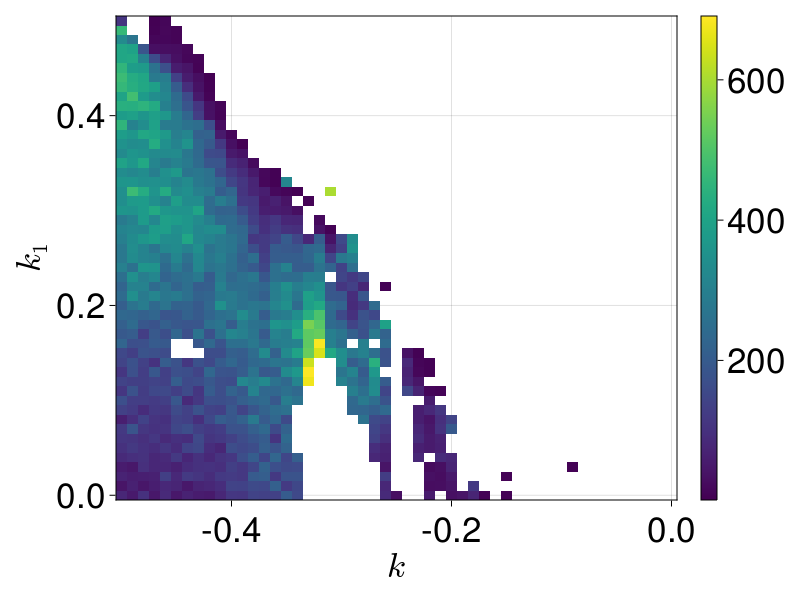

In [51]:
# k2 = 0.07
fig = Figure(fontsize = 35)
ax = Axis(fig[1, 1], xlabel = L"k", ylabel = L"k_1")
hm = heatmap!(ax, k1_space, k_space, transpose(EE_mapcopy))
Colorbar(fig[:, end+1], hm)
fig

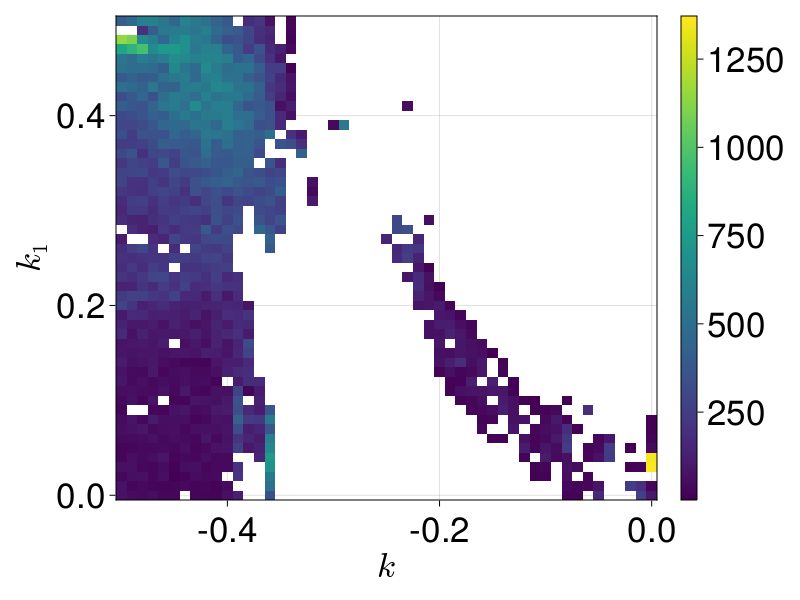

In [38]:
# k2 = -0.17
fig = Figure(fontsize = 35)
ax = Axis(fig[1, 1], xlabel = L"k", ylabel = L"k_1")
hm = heatmap!(ax, k1_space, k_space, transpose(EE_mapcopy))
Colorbar(fig[:, end+1], hm)
fig

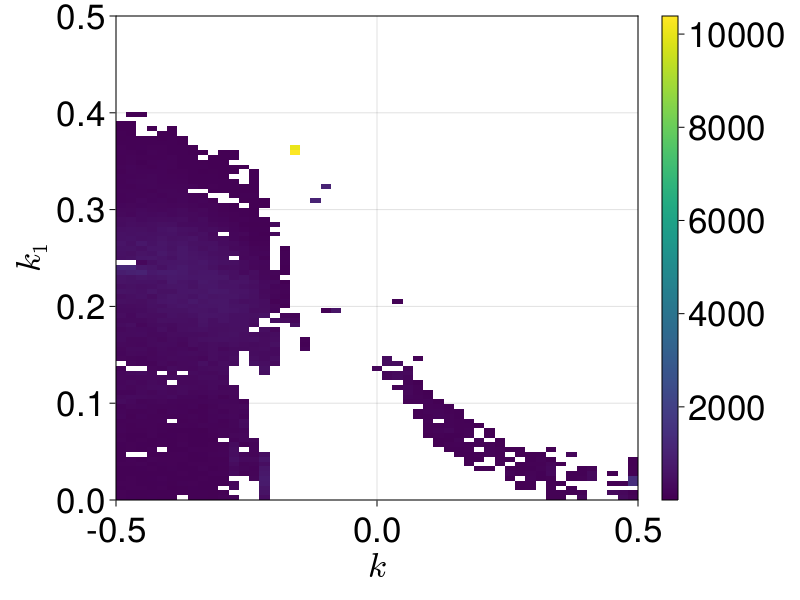

In [15]:
fig = Figure(fontsize = 35)
ax = Axis(fig[1, 1], xlabel = L"k", ylabel = L"k_1")
hm = heatmap!(ax, k1_space, k_space, transpose(EE_mapcopy))
Colorbar(fig[:, end+1], hm)
fig

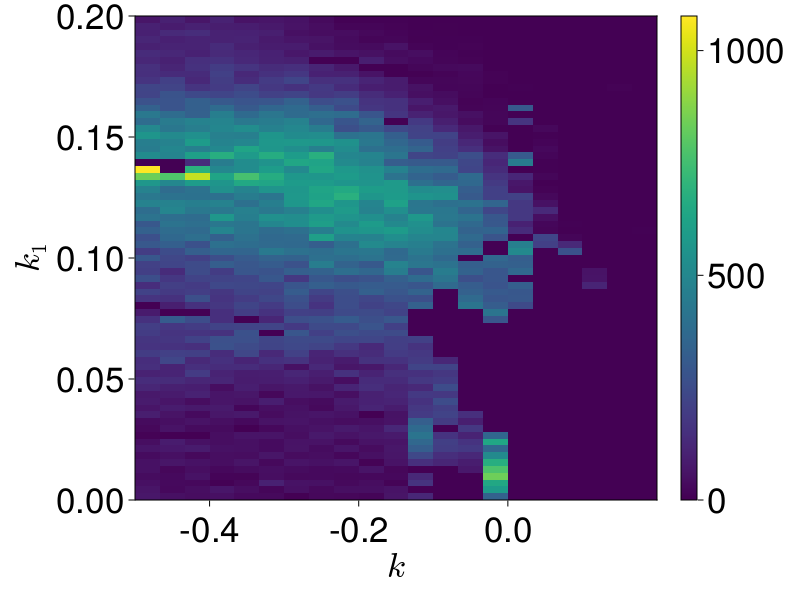

In [37]:
fig = Figure(fontsize = 35)
ax = Axis(fig[1, 1], xlabel = L"k", ylabel = L"k_1")
hm = heatmap!(ax, k1_space, k_space, transpose(EE_map))
Colorbar(fig[:, end+1], hm)
fig